# Detecting Malaria in Cell Images: A Smaller Dataset Approach

Malaria, a life-threatening disease caused by parasites transmitted through mosquito bites, continues to pose a significant global health challenge. Early and accurate detection of malaria-infected cells in blood smears is crucial for timely treatment and disease control efforts.

## Problem and Dataset Overview

In this project, we focus on developing a CNN model to detect malaria in cell images using a smaller version of the dataset. The dataset consists of microscopic images of blood smears, divided into training and testing sets:

### Training Dataset

- **Parasite**: 220 images
- **Uninfected**: 196 images

### Testing Dataset

- **Parasite**: 91 images
- **Uninfected**: 43 images

The goal is to train a convolutional neural network (CNN) model to classify these cell images accurately. The model will learn to differentiate between cells infected with malaria parasites (Parasite) and those that are uninfected (Uninfected) based on the visual features extracted from the images.

## Approach

We will use TensorFlow/Keras to implement and train a CNN model. CNNs are well-suited for image classification tasks as they can automatically learn hierarchical representations of image data. By leveraging the training dataset, we aim to optimize the model's performance in accurately identifying malaria-infected cells.

## Objectives

- Develop and train a CNN model using the training dataset to classify cell images as Parasite or Uninfected.
- Evaluate the model's performance on the testing dataset.
- Showcase the effectiveness of the model in accurately detecting malaria-infected cells, which can aid healthcare professionals in making timely diagnostic decisions.

## Importance

Accurate and automated detection of malaria through image analysis not only supports early diagnosis but also enhances healthcare responses, especially in resource-constrained regions. This project aims to contribute to the ongoing efforts in combatting malaria by leveraging machine learning techniques for efficient and reliable detection of the disease in blood smears.


## Importing all the required modules

In [53]:
# Importing all the required files

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import models, layers, Sequential
from tensorflow.keras.models import load_model, save_model

In [54]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Preparing the Dataset

The data from the training and the testing datasets is prepared using Tensorflow function. It is very useful for loading the image and automatically labeling them based on the directory structure.

In [55]:
train_path = '/kaggle/input/malaria-detection-dataset/Dataset/Train'
test_path = '/kaggle/input/malaria-detection-dataset/Dataset/Test'

In [56]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory=train_path,
            shuffle=True,
            image_size=(64,64),
            batch_size = 32,
)

Found 416 files belonging to 2 classes.


In [57]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory=test_path,
            shuffle=True,
            image_size=(62,62),
            batch_size = 32,
)

Found 134 files belonging to 2 classes.


In [58]:
classnames = train_dataset.class_names
classnames

['Parasite', 'Uninfected']

From the above, there are only 2 classname. Thus the dataset has been loaded properly and in understanding the output labels of the model.

## Sample Images

We will see some of the images that are used in the dataset with the corresponding classes.

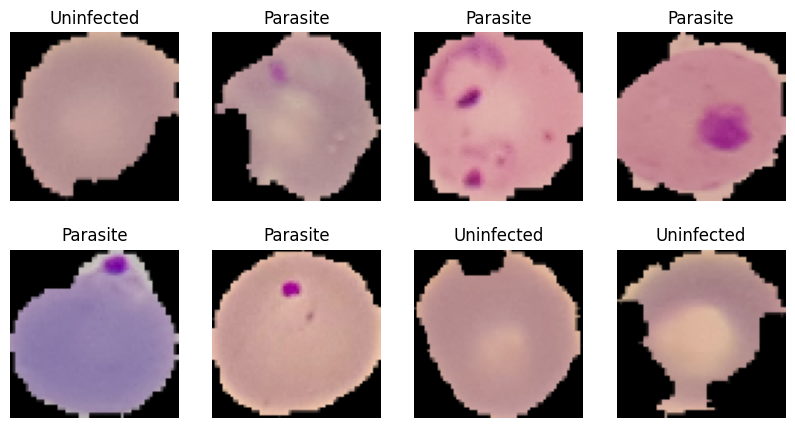

In [59]:
plt.figure(figsize=(10, 8))
for image, label in train_dataset.take(1):
    for i in range(8):
        plt.subplot(3, 4, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(classnames[label[i]])
        plt.axis('off')

## Splitting the Data

To ensure our model generalizes well to new, unseen data, we need to split our dataset into training and validation sets. We'll use **90% of the data for training and the remaining 10% for validation**. This split helps us evaluate the model's performance on a separate subset of data that it hasn't seen during training.


In [60]:
def split_data(ds, train_ratio=0.9, shuffle=True, shuffle_size=1000):
    """
    Splits a TensorFlow dataset into training and validation sets.

    Parameters:
    ds (tf.data.Dataset): The input dataset to be split.
    train_ratio (float): The proportion of the data to be used for training. Defaults to 0.9.
    shuffle (bool): Whether to shuffle the dataset before splitting. Defaults to True.
    shuffle_size (int): The buffer size for shuffling the dataset. Defaults to 1000.

    Returns:
    train_ds (tf.data.Dataset): The training dataset.
    val_ds (tf.data.Dataset): The validation dataset.
    """
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    ds_size = len(ds)
    train_size = int(ds_size * train_ratio)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size)
    
    return train_ds, val_ds

In [61]:
train_ds, val_ds = split_data(train_dataset)
len(train_ds), len(val_ds)

(11, 2)

## Optimizing

We are going to enhance the efficiency by using **caching, shuffling and prefetching the operations**. These operations help in speeding up data loading and ensure the data is fed to the model in a way that promotes better training performance.

### Caching

It caches the dataset in memory after the first epoch. This means that for subsequent epochs, the data will be loaded from memory, which is much faster than loading from disk. This significantly speeds up training by reducing data loading times.

In [62]:
train_ds = train_ds.cache()
val_ds = val_ds.cache()
test_ds = test_dataset.cache()

### Shuffling

It is a **very important step**. It ensures that the model does not learn any unintended patterns from the order of the data. By shuffling the data, we ensure that each batch contains a random mix of samples, promoting better generalization.

In [63]:
train_ds = train_ds.shuffle(100)
val_ds = val_ds.shuffle(100)
test_ds = test_dataset.shuffle(100)

### Prefetching

Operation overlaps the data preprocessing and model execution. While the model is training on one batch of data, the next batch is being preloaded. refetching helps in keeping the data pipeline efficient, ensuring that the CPU or GPU is not idle while waiting for data.

In [64]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Data Preprocessing

To prepare our images for training, we need to resize them to a consistent size and rescale their pixel values. Additionally, we apply data augmentation techniques to increase the variability of our training dataset.

### Resizing and Rescaling

In [65]:
resize_and_rescale = Sequential([
    layers.Resizing(151, 136),
    layers.Rescaling(1.0/255)
])

### Data Augmentation

To improve the diversity, we will apply random flipping and rotation techniques to imporve data augumentation.

In [66]:
data_augmentation = Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical"),
    layers.RandomRotation(factor=0.3)
])

## Modeling

### Input Shape

We will create a tuple which represents the dimensions of a single image dataset. It contains three values width, height and number of channels (RGB).

In [67]:
width = 151
height = 136
channels = 3


input_shape = (width, height, channels)

### Creating the model

In [68]:
model = Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

### Model Compilation and Training

In [69]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [70]:
history = model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.5247 - loss: 1.1881 - val_accuracy: 0.4844 - val_loss: 0.6998
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5171 - loss: 0.6880 - val_accuracy: 0.4844 - val_loss: 0.6981
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5520 - loss: 0.6870 - val_accuracy: 0.6719 - val_loss: 0.6750
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6038 - loss: 0.6720 - val_accuracy: 0.6250 - val_loss: 0.6501
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.6216 - loss: 0.6548 - val_accuracy: 0.6875 - val_loss: 0.5953
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6816 - loss: 0.6115 - val_accuracy: 0.6406 - val_loss: 0.6090
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.6982 - loss: 0.5742 - val_accuracy: 0.8125 - val_loss: 0.5017
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.7816 - loss: 0.4730 - val_accuracy: 0.7188 - val_loss:

### Summary of the model

It will give a summary of the model architecture, including the type and shape of each layer, the number of parameters, and the output shape at each layer.

In [71]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 151, 136, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 151, 136, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 149, 134, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 67, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 74, 67, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 33, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 33, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     9,437,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,449,349 (112.34 MB)

 Trainable params: 9,816,449 (37.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,632,900 (74.89 MB)

### Analyzing the model

First let us get the model history to analyze

In [72]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

Now, let us plot the graph for accuracy and loss of training and validation data

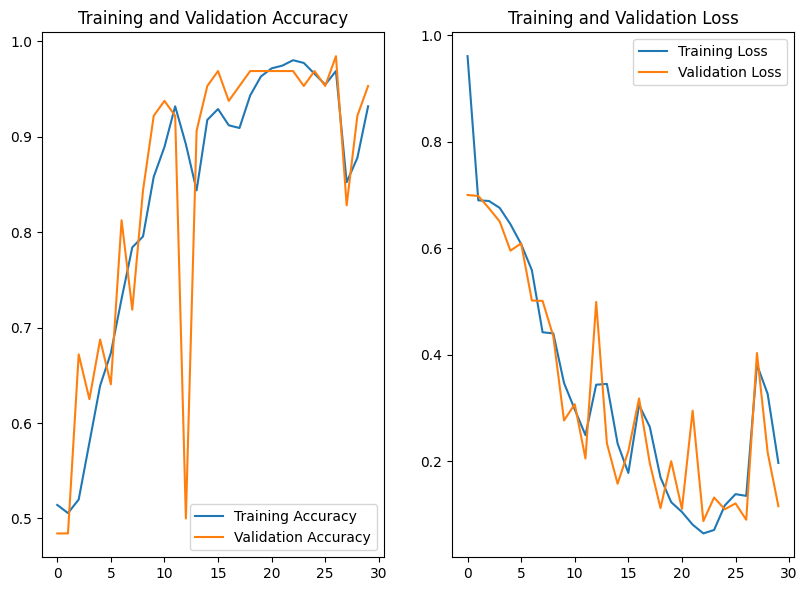

In [73]:
epochs = 30

# Plotting graphs for accuracy and loss of training and validation data
plt.figure(figsize=(15, 15))

# Plotting Training and Validation Accuracy
plt.subplot(2, 3, 1)
plt.plot(range(epochs), train_acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting Training and Validation Loss
plt.subplot(2, 3, 2)
plt.plot(range(epochs), train_loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Displaying the plots
plt.show()

## Predictions on Test Data

Predictions made by our trained model on a subset of the test dataset. Each prediction includes the actual class label, predicted class label, and the model's confidence in its prediction.


### Interpretation

- **Actual**: The actual class label of the image.
- **Predicted**: The class label predicted by our model.
- **Confidence**: The model's confidence level in its prediction, expressed as a percentage.

These visualizations provide insights into how well the model performs on unseen data, helping us evaluate its accuracy and performance in real-world applications.

In [74]:
def predict_malaria(model, img, classnames):
    """
    Predicts the class and confidence level for a given image using a trained model.

    Args:
    - model (tf.keras.Model): Trained TensorFlow/Keras model for malaria classification.
    - img (PIL.Image): Image to predict, expected to be in PIL format.
    - classnames (list): List of class names representing the prediction classes.

    Returns:
    - predicted_class (str): Predicted class label for the image.
    - confidence (float): Confidence level (in percentage) of the prediction.
    """
    # Convert image to NumPy array and expand dimensions for model input
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Predict using the model
    prediction = model.predict(img_array)

    # Determine predicted class and confidence
    if prediction[0, 0] > 0.5:
        predicted_class = classnames[1]
        confidence = (prediction[0, 0] - 0.5) * 2 * 100
    else:
        predicted_class = classnames[0]
        confidence = (0.5 - prediction[0, 0]) * 2 * 100
    
    # Round confidence to two decimal places
    confidence = round(confidence, 2)

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


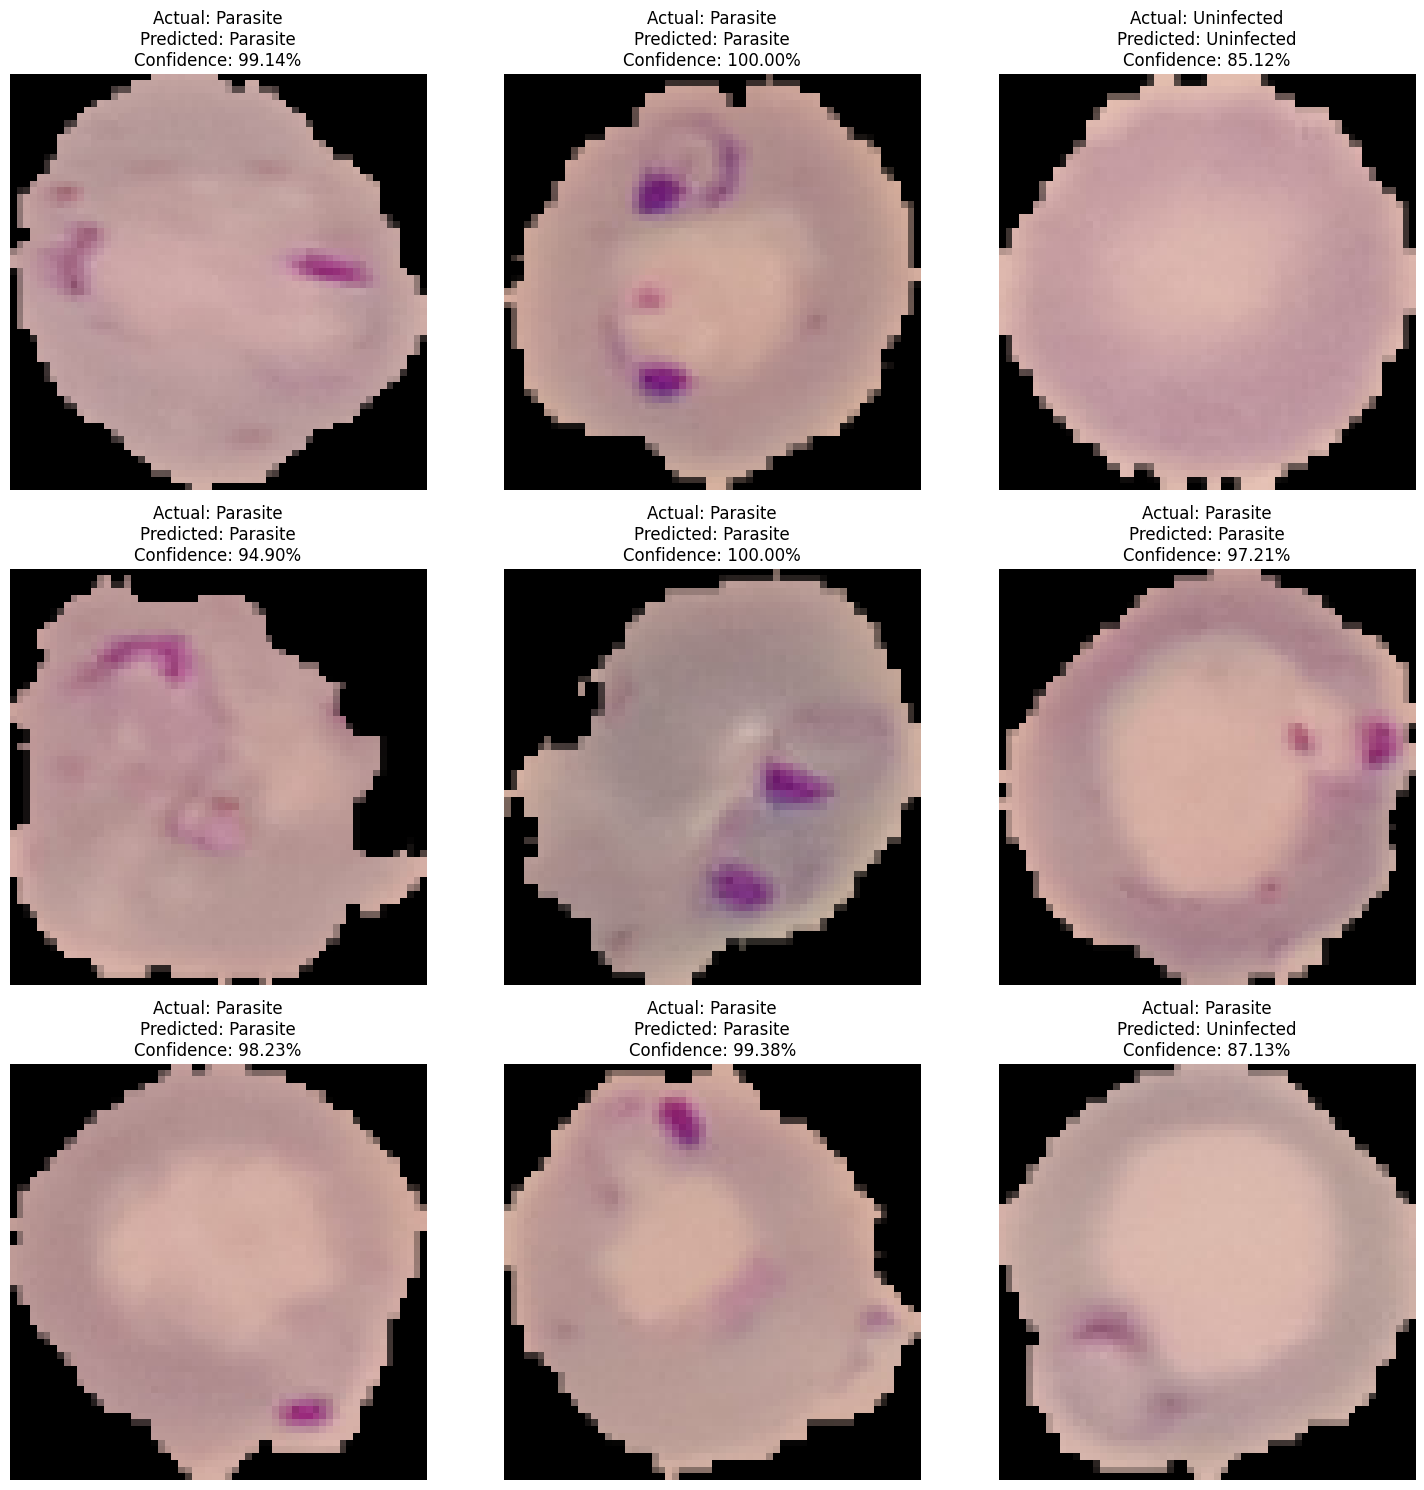

In [75]:
# Visualizing the Predictions

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict_malaria(model, images[i], classnames)
        actual_class = classnames[labels[i]]
        
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}%")
        
        plt.axis("off")

plt.tight_layout()
plt.show()

## Evaluation of the Model

In [76]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_ds)

print(f'Test accuracy: {accuracy * 100:.2f}%')

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 458ms/step - accuracy: 0.8730 - loss: 0.2970
Test accuracy: 88.06%


## Saving the model

After training and evaluating our Convolutional Neural Network (CNN) model for malaria prediction, we have saved the model to a file named `malaria_prediction.h5`. This file contains the architecture, weights, and configuration of the trained model, allowing us to reuse it later for predictions or further training.


In [ ]:
model.save('malaria_prediction.h5')

## Conclusion

In this project, we developed and trained a convolutional neural network (CNN) model to detect malaria-infected cells in blood smear images. The dataset, consisting of both infected (Parasite) and uninfected cells, was divided into training and testing sets. Through **30 epochs** of training, the model exhibited significant improvement in performance, achieving a **test accuracy of 88.06%**.

### Model Architecture

The CNN architecture consisted of multiple convolutional and pooling layers followed by dense layers for classification. With a total of 29,449,349 parameters, the model was trained using an optimizer that resulted in an optimized set of trainable parameters, totaling 9,816,449.
